In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 06:28:53] [setup] RAM Tracking...
[codecarbon INFO @ 06:28:53] [setup] GPU Tracking...
[codecarbon INFO @ 06:28:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:28:53] [setup] CPU Tracking...
[codecarbon WARNING @ 06:28:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 06:28:56] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 06:28:56] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 06:28:56] >>> Tracker's metadata:
[codecarbon INFO @ 06:28:56]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 06:28:56]   Python version: 3.11.3
[codecarbon INFO @ 06:28:56]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 06:28:56]   Available RAM : 256.000 GB
[codecarbon INFO @ 06:28:56]   CPU count: 24
[codecarbon INFO @ 06:28:56]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


qvgiavx0k854


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("../../csv/clean_Qt_balanced.csv")
fine_tuning_df


,text_clean,label
0,using this example run via qmlscene code impor...,0
1,if i happen to get two modal dialogs open at t...,1
2,the attached screenshot shows that the zapfino...,0
3,hello i have some issues with mysqlopenssl lib...,0
4,we have a few updates to webkit that the webki...,1
...,...,...
3877,this was actually with the packageto reproduce...,1
3878,a fairly sure way to cause this crash is to in...,1
3879,it seems every example in the dev branch curre...,1
3880,the style seems to have a few rough edgesthere...,0


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,using this example run via qmlscene code impor...,0
1,if i happen to get two modal dialogs open at t...,1
2,the attached screenshot shows that the zapfino...,0
3,hello i have some issues with mysqlopenssl lib...,0
4,we have a few updates to webkit that the webki...,1
...,...,...
3877,this was actually with the packageto reproduce...,1
3878,a fairly sure way to cause this crash is to in...,1
3879,it seems every example in the dev branch curre...,1
3880,the style seems to have a few rough edgesthere...,0


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
3432,mingw version of gcc bundled with qt has a ver...,1
1018,pressing a button inside a mousearea and then ...,0
1941,due to a malfunctioning script all the fastfor...,1
3614,introduced by change,1
1200,codejava import qtquick text textformat textpl...,0
...,...,...
1171,building existing project eg any example in wi...,1
1295,noformat fail tstcontrolstestopenduringexittra...,0
361,creation of work items failed most recent call...,1
135,there is no way to propagate errors from an im...,0


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
95267,building existing project eg any example in wi...,1
95268,noformat fail tstcontrolstestopenduringexittra...,0
95269,creation of work items failed most recent call...,1
95270,there is no way to propagate errors from an im...,0


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        16059
       0        15699
1      0        15987
       1        15770
2      0        15903
       1        15854
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,1
1,its been over hrs since the mirror has been up...,0,2
2,there has been discussion on the mailing lists...,0,0
3,when elytron client tries to obtain clientconf...,1,2
4,need to be able to release all items at once v...,1,1
...,...,...,...
95267,building existing project eg any example in wi...,1,0
95268,noformat fail tstcontrolstestopenduringexittra...,0,2
95269,creation of work items failed most recent call...,1,1
95270,there is no way to propagate errors from an im...,0,2


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1985/1985 [04:18<00:00,  7.69it/s, Epoch=1, LR=9.67e-6, Valid_Loss=0.575]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7197    0.6463    0.6810     15699
          HP     0.6856    0.7540    0.7181     16059

    accuracy                         0.7007     31758
   macro avg     0.7027    0.7001    0.6996     31758
weighted avg     0.7025    0.7007    0.6998     31758

Accuracy = 0.7007
F1_score = 0.7181
Validation Loss Improved (inf ---> 0.5746019584712637)
Model Saved



100%|██████████| 1985/1985 [04:18<00:00,  7.69it/s, Epoch=2, LR=8.74e-6, Valid_Loss=0.593]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6351    0.7809    0.7005     15699
          HP     0.7238    0.5614    0.6323     16059

    accuracy                         0.6699     31758
   macro avg     0.6794    0.6711    0.6664     31758
weighted avg     0.6799    0.6699    0.6660     31758

Accuracy = 0.6699
F1_score = 0.6323



100%|██████████| 1985/1985 [04:18<00:00,  7.69it/s, Epoch=3, LR=7.34e-6, Valid_Loss=0.573]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7169    0.6955    0.7061     15699
          HP     0.7108    0.7316    0.7210     16059

    accuracy                         0.7137     31758
   macro avg     0.7139    0.7135    0.7135     31758
weighted avg     0.7138    0.7137    0.7136     31758

Accuracy = 0.7137
F1_score = 0.721
Validation Loss Improved (0.5746019584712637 ---> 0.5730217684838519)
Model Saved

Training complete in 1h 43m 14s
Best Loss: 0.5730


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▆▁█
Valid F1_score,█▁█
Valid Loss,▂█▁
Best Loss,0.57302
Train Loss,0.51511
Valid Accuracy,0.7137
Valid F1_score,0.721
Valid Loss,0.57302



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1985/1985 [04:21<00:00,  7.60it/s, Epoch=1, LR=9.67e-6, Valid_Loss=0.579]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6725    0.7460    0.7074     15987
          HP     0.7105    0.6317    0.6688     15770

    accuracy                         0.6893     31757
   macro avg     0.6915    0.6889    0.6881     31757
weighted avg     0.6914    0.6893    0.6882     31757

Accuracy = 0.6893
F1_score = 0.6688
Validation Loss Improved (inf ---> 0.5793657817764599)
Model Saved



100%|██████████| 1985/1985 [04:21<00:00,  7.60it/s, Epoch=2, LR=8.74e-6, Valid_Loss=0.575]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7730    0.5265    0.6264     15987
          HP     0.6372    0.8432    0.7259     15770

    accuracy                         0.6838     31757
   macro avg     0.7051    0.6849    0.6761     31757
weighted avg     0.7056    0.6838    0.6758     31757

Accuracy = 0.6838
F1_score = 0.7259
Validation Loss Improved (0.5793657817764599 ---> 0.5753859146534656)
Model Saved



100%|██████████| 1985/1985 [04:21<00:00,  7.60it/s, Epoch=3, LR=7.34e-6, Valid_Loss=0.562]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7417    0.6393    0.6867     15987
          HP     0.6792    0.7743    0.7236     15770

    accuracy                         0.7063     31757
   macro avg     0.7105    0.7068    0.7052     31757
weighted avg     0.7107    0.7063    0.7050     31757

Accuracy = 0.7063
F1_score = 0.7236
Validation Loss Improved (0.5753859146534656 ---> 0.5622331346541931)
Model Saved

Training complete in 1h 43m 38s
Best Loss: 0.5622


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▃▁█
Valid F1_score,▁██
Valid Loss,█▆▁
Best Loss,0.56223
Train Loss,0.5166
Valid Accuracy,0.7063
Valid F1_score,0.7236
Valid Loss,0.56223



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1985/1985 [04:24<00:00,  7.51it/s, Epoch=1, LR=9.67e-6, Valid_Loss=0.581]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7239    0.6025    0.6576     15903
          HP     0.6587    0.7695    0.7098     15854

    accuracy                         0.6858     31757
   macro avg     0.6913    0.6860    0.6837     31757
weighted avg     0.6913    0.6858    0.6836     31757

Accuracy = 0.6858
F1_score = 0.7098
Validation Loss Improved (inf ---> 0.5812380170928751)
Model Saved



100%|██████████| 1985/1985 [04:24<00:00,  7.51it/s, Epoch=2, LR=8.74e-6, Valid_Loss=0.569]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6870    0.7381    0.7117     15903
          HP     0.7161    0.6627    0.6884     15854

    accuracy                         0.7005     31757
   macro avg     0.7016    0.7004    0.7000     31757
weighted avg     0.7016    0.7005    0.7000     31757

Accuracy = 0.7005
F1_score = 0.6884
Validation Loss Improved (0.5812380170928751 ---> 0.5687276425802179)
Model Saved



100%|██████████| 1985/1985 [04:24<00:00,  7.51it/s, Epoch=3, LR=7.34e-6, Valid_Loss=0.569]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6960    0.7394    0.7171     15903
          HP     0.7212    0.6761    0.6979     15854

    accuracy                         0.7078     31757
   macro avg     0.7086    0.7078    0.7075     31757
weighted avg     0.7086    0.7078    0.7075     31757

Accuracy = 0.7078
F1_score = 0.6979

Training complete in 1h 44m 1s
Best Loss: 0.5687


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,█▁▄
Valid Loss,█▁▁
Best Loss,0.56873
Train Loss,0.51797
Valid Accuracy,0.7078
Valid F1_score,0.6979
Valid Loss,0.56928


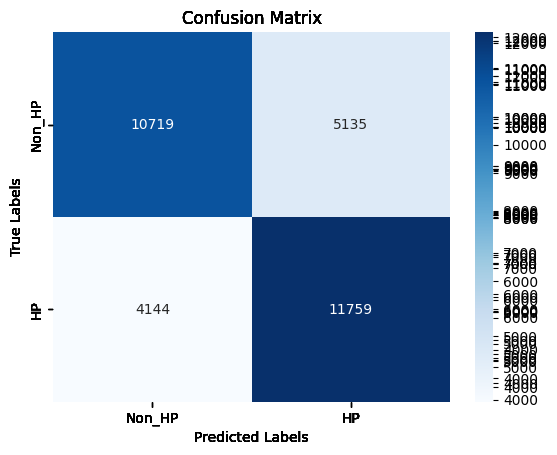

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
1151,the documentation for qdatawidgetmapper indica...,0
2586,currently moc supports qnamespace only in top ...,0
1053,in cups my printer is configured to use duplex...,0
3222,component qtqtimageformats fails to build agai...,1
22,update submodules on in code homeqtworkqtqtxml...,1
...,...,...
1130,i have a timeline with objects in it done with...,0
1294,compiling single module with yocto sdk works f...,0
860,the performance of graphicsview on maemo devic...,0
3507,after updating to qt creator half of tests of ...,0


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 170/170 [00:27<00:00,  6.26it/s]


Fold 1


100%|██████████| 170/170 [00:27<00:00,  6.27it/s]


Fold 2


100%|██████████| 170/170 [00:27<00:00,  6.27it/s]


In [45]:
deberta_predictions


[array([[0.7795904 , 0.22040963],
        [0.84727323, 0.15272684],
        [0.7802052 , 0.21979481],
        ...,
        [0.82779217, 0.17220789],
        [0.35605487, 0.6439451 ],
        [0.56759495, 0.43240505]], dtype=float32),
 array([[0.77456236, 0.22543769],
        [0.5374026 , 0.46259746],
        [0.50455064, 0.49544936],
        ...,
        [0.5980342 , 0.4019658 ],
        [0.29014215, 0.7098579 ],
        [0.38116258, 0.6188374 ]], dtype=float32),
 array([[0.6902293 , 0.30977067],
        [0.7108564 , 0.28914362],
        [0.5625725 , 0.43742752],
        ...,
        [0.6823343 , 0.31766567],
        [0.372957  , 0.627043  ],
        [0.62463635, 0.37536368]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.7481273 , 0.25187266],
       [0.6985107 , 0.30148932],
       [0.6157761 , 0.3842239 ],
       ...,
       [0.70272017, 0.2972798 ],
       [0.339718  , 0.66028196],
       [0.5244646 , 0.4755354 ]], dtype=float32)

In [47]:
len(predictions)

2718

In [48]:
predictions

array([[0.7481273 , 0.25187266],
       [0.6985107 , 0.30148932],
       [0.6157761 , 0.3842239 ],
       ...,
       [0.70272017, 0.2972798 ],
       [0.339718  , 0.66028196],
       [0.5244646 , 0.4755354 ]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1151,the documentation for qdatawidgetmapper indica...,0,0.748127,0.251873,0,0,0
2586,currently moc supports qnamespace only in top ...,0,0.698511,0.301489,0,0,0
1053,in cups my printer is configured to use duplex...,0,0.615776,0.384224,0,0,0
3222,component qtqtimageformats fails to build agai...,1,0.243427,0.756573,1,1,1
22,update submodules on in code homeqtworkqtqtxml...,1,0.272669,0.727331,1,1,1
...,...,...,...,...,...,...,...
1130,i have a timeline with objects in it done with...,0,0.435946,0.564053,1,1,0
1294,compiling single module with yocto sdk works f...,0,0.400686,0.599314,1,1,1
860,the performance of graphicsview on maemo devic...,0,0.702720,0.297280,0,0,0
3507,after updating to qt creator half of tests of ...,0,0.339718,0.660282,1,1,1


In [53]:
len(test_df)

2718

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1151,the documentation for qdatawidgetmapper indica...,0,0.748127,0.251873,0,0,0,prediction_0,0
2586,currently moc supports qnamespace only in top ...,0,0.698511,0.301489,0,0,0,prediction_0,0
1053,in cups my printer is configured to use duplex...,0,0.615776,0.384224,0,0,0,prediction_0,0
3222,component qtqtimageformats fails to build agai...,1,0.243427,0.756573,1,1,1,prediction_1,1
22,update submodules on in code homeqtworkqtqtxml...,1,0.272669,0.727331,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
1130,i have a timeline with objects in it done with...,0,0.435946,0.564053,1,1,0,prediction_1,1
1294,compiling single module with yocto sdk works f...,0,0.400686,0.599314,1,1,1,prediction_1,1
860,the performance of graphicsview on maemo devic...,0,0.702720,0.297280,0,0,0,prediction_0,0
3507,after updating to qt creator half of tests of ...,0,0.339718,0.660282,1,1,1,prediction_1,1


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[1039  337]
 [ 250 1092]]


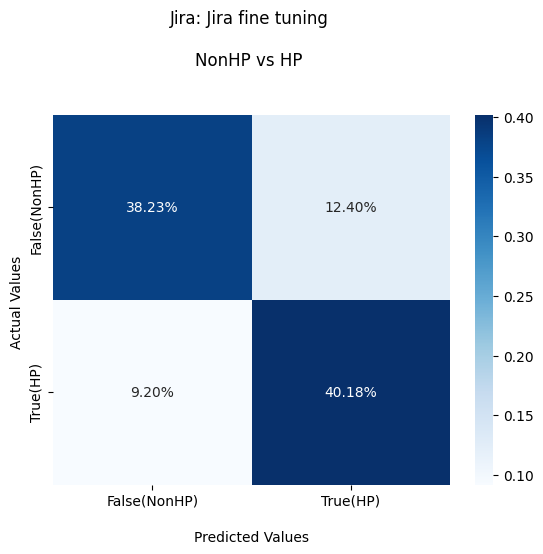

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira: Jira fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1376
           1       0.76      0.81      0.79      1342

    accuracy                           0.78      2718
   macro avg       0.79      0.78      0.78      2718
weighted avg       0.79      0.78      0.78      2718



In [62]:
test_df[["text","label","pred"]].to_csv("MongoDB_70_Test_inference.csv")

In [63]:
tracker.stop()

0.04854080324859039